# Text Features Demo (Revised)

This notebook demonstrates the text-based features implemented in the recommendation system. These features aim to capture semantic relationships between products, and between products and users' historical interactions, to create more personalized and relevant recommendations.

In [1]:
import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For better plot aesthetics
from IPython.display import display
from pathlib import Path

from lavka_recsys import Config, Experiment, setup_logging

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
setup_logging()

<Logger lavka_recsys (DEBUG)>

## 1. Load Configuration and Define Text Features

We'll load the default configuration and then explicitly define which text features we want to test. 
**Important Note on Embedding Dimensions:** The `num_cols` parameter in the `@FeatureFactory.register` decorators within `text_processor.py` (e.g., for `product_embeddings`, `category_embeddings`) must align with the actual number of embedding dimensions produced. This dimension is controlled by `text_processing.embedding_dimensions` in the configuration if PCA reduction is applied, or it's the raw embedding size of the pre-trained model. For this demo, we'll set it explicitly.

In [2]:
# Load base configuration from file
config = Config.load('default_config.yaml')

# Define the text feature generator names as registered in text_processor.py
ALL_TEXT_FEATURE_GENERATORS = [
    'product_embeddings',          # Generates product_embed_X columns
    'category_embeddings',         # Generates cat_embed_X columns
    # 'user_product_similarity',     # Generates similarity scores (weighted, max history)
    'text_similarity_cluster',     # Generates product_text_cluster and cluster_X_ratio columns
    'text_diversity_features'      # Generates distance_from_centroid, relative_diversity
]

# This MUST match the num_cols in their respective @FeatureFactory.register decorators in text_processor.py
config.set('text_processing.embedding_dimensions', 20) 

print(f"Base configuration loaded. Intended text features for demo: {ALL_TEXT_FEATURE_GENERATORS}")
print(f"Configured embedding dimensions (after potential PCA): {config['feature_config.text_processing.embedding_dimensions']}")
print(f"Configured number of text clusters: {config['feature_config.text_processing.n_clusters']}")

Base configuration loaded. Intended text features for demo: ['product_embeddings', 'category_embeddings', 'text_similarity_cluster', 'text_diversity_features']
Configured embedding dimensions (after potential PCA): 20
Configured number of text clusters: 15


## 2. Feature Overview (Updated)

Let's review the text features we'll be demonstrating (names reflect the revised `text_processor.py`):

1.  **`product_embeddings`**: Generates dense vector representations (embeddings) for product names.
    * Outputs columns like `product_embed_0`, `product_embed_1`, ...
2.  **`category_embeddings`**: Generates embeddings for product category names.
    * Outputs columns like `cat_embed_0`, `cat_embed_1`, ...
3.  **`user_product_similarity`**: Calculates similarity scores between target products and a user's historical interactions (purchases, cart additions) based on their embeddings.
    * `purchase_weighted_similarity`: Cosine similarity to the weighted average embedding of user's purchased items.
    * `cart_weighted_similarity`: Cosine similarity to the weighted average embedding of user's cart items.
    * `max_purchase_similarity_history`: Maximum cosine similarity to any single item previously purchased by the user.
    * `max_cart_similarity_history`: Maximum cosine similarity to any single item previously added to cart by the user.
4.  **`text_similarity_cluster`**: Clusters products based on the semantic similarity of their text embeddings (e.g., product names).
    * `product_text_cluster` (Categorical): The ID of the semantic cluster the product belongs to.
    * `cluster_purchase_ratio`: Ratio of a user's purchases from the target product's cluster to their total purchases.
    * `cluster_cart_ratio`: Ratio of a user's cart additions from the target product's cluster.
    * `cluster_view_ratio`: Ratio of a user's views from the target product's cluster.
5.  **`text_diversity_features`**: Measures how textually different or novel a target product is compared to the user's historical interactions.
    * `distance_from_centroid`: Euclidean distance between the target product's embedding and the centroid of the user's historically interacted items' embeddings.
    * `relative_diversity`: The `distance_from_centroid` normalized by the user's average historical interaction diversity.

These features help capture semantic relationships and user preferences that might be missed by traditional collaborative filtering or count-based features, especially for new or rare items.

## 3. Run Experiment with Text Features

Let's configure and run an experiment that includes all our text features.

In [ ]:
# Set experiment name and output directory
experiment_name_with_text = "text_features_demo_with_text"
results_dir_with_text = Path(config.get('output.results_dir', 'results')) / experiment_name_with_text
os.makedirs(results_dir_with_text, exist_ok=True)

# Add text features to the list of features to be generated
current_features = config.get('features', [])
updated_features = list(set(current_features + ALL_TEXT_FEATURE_GENERATORS)) # Use set to avoid duplicates

# Configure experiment settings for the demo
text_exp_config = (
    config
    .set('features', updated_features)
    .set('experiment.type', 'single_run')
    .set('experiment.use_hyperparameter_tuning', False)
    .set('output.results_dir', str(results_dir_with_text))
    .set('data.sample_fraction', config.get('data.sample_fraction', 0.1)) 
)

print(f"Running experiment WITH text features. Output directory: {results_dir_with_text}")
print(f"Features to be generated: {text_exp_config.get('features')}")

# Create and run experiment
text_experiment_runner = Experiment(experiment_name_with_text, text_exp_config)
text_experiment_runner.setup()
results_with_text = text_experiment_runner.run()
print("Experiment WITH text features completed.")

Running experiment WITH text features. Output directory: results/text_features_demo_with_text
Features to be generated: None
2025-05-18 01:29:27,523 - lavka_recsys.Experiment(text_features_demo_with_text_d8cd8e) - INFO - Initialized experiment: text_features_demo_with_text_d8cd8e
2025-05-18 01:29:27,531 - lavka_recsys.Experiment(text_features_demo_with_text_d8cd8e) - INFO - Config saved: results/text_features_demo_with_text/text_features_demo_with_text_d8cd8e_config.json
2025-05-18 01:29:27,532 - lavka_recsys.Experiment(text_features_demo_with_text_d8cd8e) - INFO - Setting up experiment environment...
2025-05-18 01:29:27,534 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-18 01:29:27,819 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-18 01:29:28,177 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-18 01:29:28,203 - lavka_recsys.DataLoader - INFO -   train:	2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-18 01:29:28,207 - lavka_recsys.DataLoader - INFO -   holdout:	2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-18 01:29:28,208 - lavka_recsys.Experiment(text_features_demo_with_text_d8cd8e) - INFO - Setup complete.
2025-05-18 01:29:28,209 - lavka_recsys.Experiment(text_features_demo_with_text_d8cd8e) - INFO - Starting experiment run...
2025-05-18 01:29:28,835 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-18 01:29:28,857 - lavka_recsys.DataLoader - INFO -   train_history:	2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-18 01:29:28,860 - lavka_recsys.DataLoader - INFO -   train_target:	2023-

  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1213 [00:00<?, ?it/s]

2025-05-18 01:30:39,532 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Initializing TextProcessor with model: sentence-transformers - paraphrase-multilingual-MiniLM-L12-v2
2025-05-18 01:30:43,239 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Loaded sentence-transformers model: paraphrase-multilingual-MiniLM-L12-v2
2025-05-18 01:30:43,251 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Generating embeddings for unique product_id from product_name
2025-05-18 01:31:01,151 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Reduced embeddings from 384 to 20 dimensions using PCA.
2025-05-18 01:31:01,159 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Generated and cached embeddings for product_id with shape (24610, 21)
2025-05-18 01:31:01,278 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Generating embeddings for unique product_category from product_cate

  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1282 [00:00<?, ?it/s]

2025-05-18 01:33:13,254 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Using cached embeddings for product_id with key product_id_sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2_20
2025-05-18 01:33:13,345 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Using cached embeddings for product_category with key product_category_sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2_20
2025-05-18 01:33:13,411 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Starting text_similarity_cluster generation.
2025-05-18 01:33:13,423 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Using cached embeddings for product_id with key product_id_sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2_20
2025-05-18 01:33:15,471 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Clustered 24610 products into 15 clusters.
2025-05-18 01:33:16,545 - lavka_recsys.lavka_recsys.feature

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, PrecisionAt, RecallAt, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-18 01:34:56,095 - lavka_recsys.Experiment(text_features_demo_with_text_d8cd8e) - INFO - Training completed in 47.91s
2025-05-18 01:34:56,102 - lavka_recsys.Experiment(text_features_demo_with_text_d8cd8e) - INFO - Evaluating on holdout.
2025-05-18 01:34:56,208 - lavka_recsys.CachedFeatureFactory - INFO - Generating feature batch
2025-05-18 01:34:56,210 - lavka_recsys.FeatureFactory - INFO - Invoking feature generators: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features_cycl, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf, bpr-popular, product_embeddings, category_embeddings, text_similarity_cluster, text_diversity_features


  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1283 [00:00<?, ?it/s]

2025-05-18 01:36:20,915 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Using cached embeddings for product_id with key product_id_sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2_20
2025-05-18 01:36:21,017 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Using cached embeddings for product_category with key product_category_sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2_20
2025-05-18 01:36:21,099 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Starting text_similarity_cluster generation.
2025-05-18 01:36:21,109 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Using cached embeddings for product_id with key product_id_sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2_20
2025-05-18 01:36:23,132 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Clustered 24610 products into 15 clusters.
2025-05-18 01:36:24,374 - lavka_recsys.lavka_recsys.feature

## 4. Analyze Results and Feature Importance (With Text Features)

Let's examine the metrics and see how important our text features are in the model.


Experiment Metrics (WITH Text Features):
  auc: 0.6970
  logloss: 1.1234
  ndcg@10: 0.4556


/tmp/ipykernel_3818775/3328268183.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.head(top_n), palette='viridis')


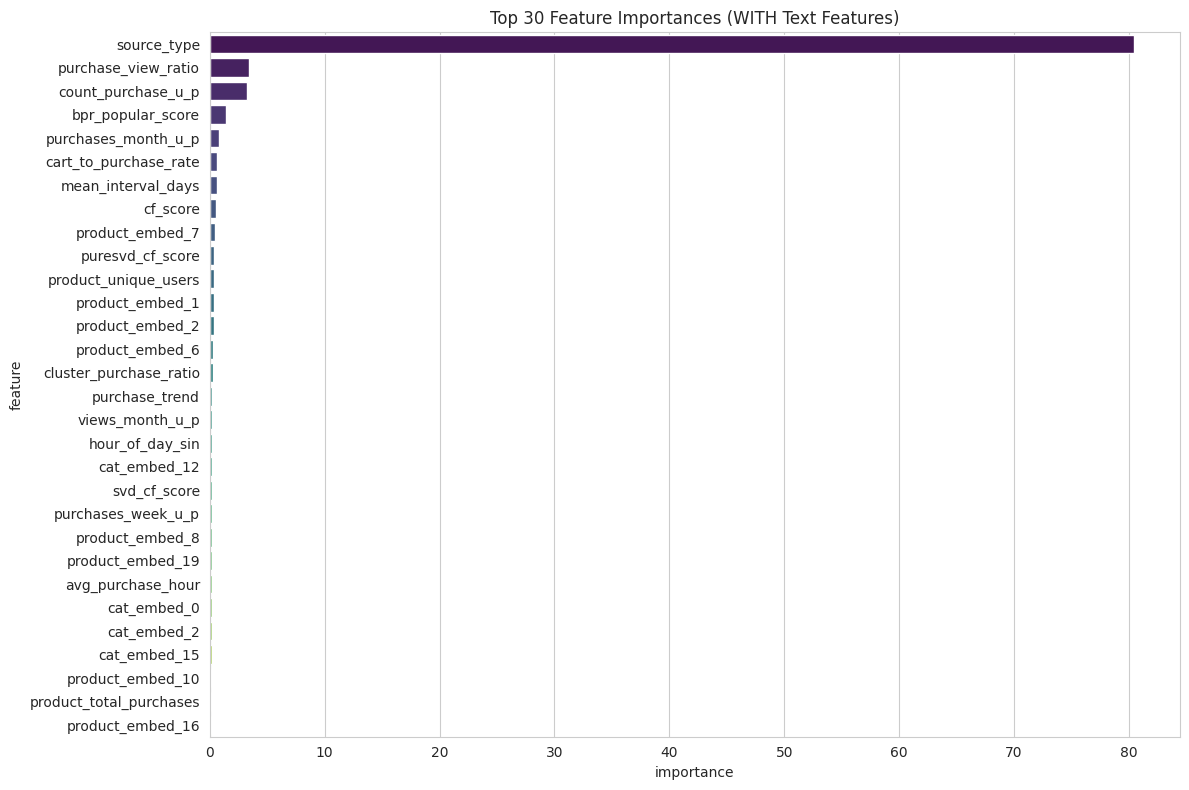


Text Feature Importances (from model with text features):


,feature,importance
15,product_embed_7,0.419673
103,product_embed_1,0.353306
79,product_embed_2,0.340840
67,product_embed_6,0.287315
101,cluster_purchase_ratio,0.287208
46,cat_embed_12,0.208521
56,product_embed_8,0.176389
12,product_embed_19,0.174017
35,cat_embed_0,0.166141
43,cat_embed_2,0.165790


In [5]:
print("\nExperiment Metrics (WITH Text Features):")
for metric, value in results_with_text['metrics'].items():
    print(f"  {metric}: {value:.4f}")

importances = results_with_text['feature_importance']
if importances:
    importance_df = pd.DataFrame({
        'feature': list(importances.keys()),
        'importance': list(importances.values())
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    top_n = min(30, len(importance_df))
    sns.barplot(x='importance', y='feature', data=importance_df.head(top_n), palette='viridis')
    plt.title(f'Top {top_n} Feature Importances (WITH Text Features)')
    plt.tight_layout()
    plt.show()
    
    # Define patterns to identify text-based features by their typical name components
    text_feature_patterns = [
        'embed', 'similarity', 'cluster', 'diversity', 'centroid', 
        'product_text_cluster' 
    ]
    text_feature_regex = '|'.join(text_feature_patterns)
    
    text_importance_df = importance_df[importance_df['feature'].str.contains(text_feature_regex, case=False, na=False)]
    
    print("\nText Feature Importances (from model with text features):")
    if not text_importance_df.empty:
        display(text_importance_df)

## 5. Run Comparison Experiment Without Text Features

To quantify the impact, let's run a similar experiment but explicitly exclude our text feature generators.

In [13]:
experiment_name_no_text = "text_features_demo_no_text"
results_dir_no_text = Path(config.get('output.results_dir', 'results')) / experiment_name_no_text
os.makedirs(results_dir_no_text, exist_ok=True)

# Exclude text features
base_features = config.get('feature_generators', [])
features_without_text_generators = [f for f in base_features if f not in ALL_TEXT_FEATURE_GENERATORS]
# Configure experiment settings
no_text_exp_config = (
    config
    .set('feature_generators', features_without_text_generators)
    .set('experiment.type', 'single_run')
    .set('output.results_dir', str(results_dir_no_text))
    .set('data.sample_fraction', config.get('data.sample_fraction', 0.1))
)

print(f"Running experiment WITHOUT text features. Output directory: {results_dir_no_text}")
print(f"Features to be generated: {no_text_exp_config.get('feature_generators')}")

Running experiment WITHOUT text features. Output directory: results/text_features_demo_no_text
Features to be generated: ['source_type', 'count_purchase_user_product', 'count_purchase_user_store', 'ctr_product', 'cart_to_purchase_rate', 'purchase_view_ratio', 'recency_user_product', 'user_stats', 'product_stats', 'store_stats', 'city_stats', 'product_temporal_patterns', 'recency_user_store', 'time_features_cycl', 'time_window_user_product', 'session_features', 'frequency_features', 'product_popularity_trend', 'cross_features', 'user_segments', 'memory-based-cf', 'npmi-cf', 'puresvd-cf', 'svd-cf', 'bpr-popular']


In [14]:
# Create and run experiment
results_no_text = None
no_text_experiment_runner = Experiment(experiment_name_no_text, no_text_exp_config)
no_text_experiment_runner.setup()
results_no_text = no_text_experiment_runner.run()
print("Experiment WITHOUT text features completed.")

2025-05-18 01:45:49,083 - lavka_recsys.Experiment(text_features_demo_no_text_9ce56e) - INFO - Initialized experiment: text_features_demo_no_text_9ce56e
2025-05-18 01:45:49,106 - lavka_recsys.Experiment(text_features_demo_no_text_9ce56e) - INFO - Config saved: results/text_features_demo_no_text/text_features_demo_no_text_9ce56e_config.json
2025-05-18 01:45:49,108 - lavka_recsys.Experiment(text_features_demo_no_text_9ce56e) - INFO - Setting up experiment environment...
2025-05-18 01:45:49,110 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet
2025-05-18 01:45:49,330 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-18 01:45:49,585 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-18 01:45:49,611 - lavka_recsys.DataLoader - INFO -   train:	2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-18 01:45:49,615 - lavka_recsys.DataLoader - INFO -   holdout:	2024-01-03 17:56:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, PrecisionAt, RecallAt, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-18 01:46:30,463 - lavka_recsys.Experiment(text_features_demo_no_text_9ce56e) - INFO - Training completed in 38.21s
2025-05-18 01:46:30,465 - lavka_recsys.Experiment(text_features_demo_no_text_9ce56e) - INFO - Evaluating on holdout.
2025-05-18 01:46:31,793 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-18 01:46:32,022 - lavka_recsys.CatBoostRankerModel - INFO - Sorting data by group_id for grouped ranking
2025-05-18 01:46:34,161 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'is_weekend' to string for CatBoost
2025-05-18 01:46:34,413 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'user_segment' to string for CatBoost
2025-05-18 01:46:34,433 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'source_type' to string for CatBoost
2025-05-18 01:46:34,451 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'city_name' to string for CatBoost
2025-05-18 01:46:45,971 - lavka_recsys.Experiment(text_features_demo_no_text_9ce56e) - IN

## 6. Compare Performance

Let's visualize the performance difference between the model trained with text features and the one without.

,With Text Features,Without Text Features
Metric,,
auc,0.697003,0.695500
logloss,1.123432,1.125352
ndcg@10,0.455604,0.453790


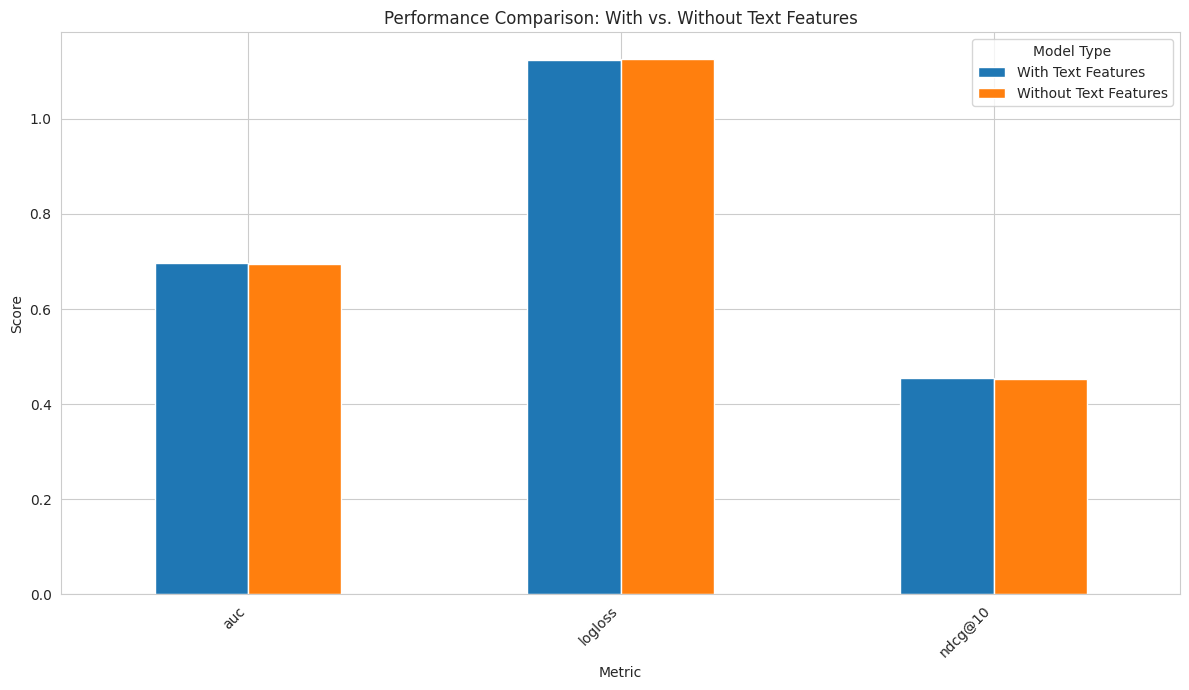


Percentage Improvement with Text Features:
  auc: 0.22%
  logloss: -0.17%
  ndcg@10: 0.40%


In [16]:
metrics_with = results_with_text['metrics']
metrics_without = results_no_text['metrics']

# Get common metrics for fair comparison
common_metric_keys = sorted(list(set(metrics_with.keys()) & set(metrics_without.keys())))

metrics_to_plot_df = pd.DataFrame({
    'Metric': common_metric_keys,
    'With Text Features': [metrics_with.get(m, 0) for m in common_metric_keys],
    'Without Text Features': [metrics_without.get(m, 0) for m in common_metric_keys]
})

display(metrics_to_plot_df.set_index('Metric'))

# Plotting
metrics_to_plot_df.set_index('Metric').plot(kind='bar', figsize=(12, 7))
plt.title('Performance Comparison: With vs. Without Text Features')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()

print("\nPercentage Improvement with Text Features:")
for metric_name in common_metric_keys:
    val_with = metrics_with.get(metric_name, 0)
    val_without = metrics_without.get(metric_name, 0)
    if val_without != 0:  
        improvement = ((val_with - val_without) / abs(val_without)) * 100
        print(f"  {metric_name}: {improvement:.2f}%")
    elif val_with > 0:
            print(f"  {metric_name}: N/A (baseline is 0, new score is {val_with:.4f})")
    else:
            print(f"  {metric_name}: N/A (both scores are 0 or baseline is 0)")

## 7. Conclusion & Next Steps

In this notebook, we've demonstrated the integration and potential impact of several text-based features. By comparing model performance with and without these features, we can assess their contribution.

Key takeaways:
* Text features can capture semantic nuances that other feature types might miss.
* The importance of individual text features can vary depending on the dataset and model.
* Careful configuration (e.g., embedding dimensions, model choices for `TextProcessor`) is important.

Potential next steps for further improvement:
* **Hyperparameter Tuning**: Tune the parameters of the text processing (e.g., `embedding_dimensions`, `n_clusters`) and the main recommendation model (e.g., CatBoost parameters) when text features are included.
* **Advanced Text Models**: Experiment with larger or more domain-specific pre-trained models for `TextProcessor` if computational resources allow.
* **Different Similarity/Distance Metrics**: Explore alternatives to cosine similarity or Euclidean distance where appropriate.
* **Interaction with Other Features**: Investigate how text features interact with other existing features in your model.
* **Error Analysis**: Deep dive into cases where the model with text features performs significantly better or worse to understand their effect more granularly.